In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.io import imread


from tqdm import tqdm
import pickle

# 병렬연산
from concurrent.futures import ThreadPoolExecutor

import os
import warnings
warnings.filterwarnings(action='ignore')

import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split

In [3]:
### 사용자 정의 함수
%cd /content/drive/MyDrive/project3

# Add the paths to the modules to the Python path
import sys
sys.path.append(os.path.abspath('./code/image_function'))

from image_load import resize_image, load_image, load_and_resize_images
from vram_reset import reset_vram

/content/drive/.shortcut-targets-by-id/1gdU-KuXDUU7v2o8X7TdV0JgGiz603mCc/project3


In [4]:
datadir = '/content/drive/MyDrive/project3/data/traindata/kfood/'

food_middle_list = sorted(os.listdir(datadir))
food_middle_list[:5]

['구이', '국', '기타', '김치', '나물']

In [5]:
food_middle_list = [] # 중분류
food_path_list = [] # 중분류 경로
datadir = '/content/drive/MyDrive/project3/data/traindata/kfood/'
for food_middle in sorted(os.listdir(datadir)):
    middle_path = os.path.join(datadir,food_middle)
    food_middle_list.append(food_middle)

    for food in os.listdir(middle_path):
      path = os.path.join(middle_path, food)
      food_path_list.append(path)

print(len(food_middle_list))
print(food_middle_list)
print(food_path_list)

13
['구이', '국', '기타', '김치', '나물', '떡', '만두', '면', '무침', '밥', '볶음', '쌈', '음청류']
['/content/drive/MyDrive/project3/data/traindata/kfood/구이/갈비구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/갈치구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/고등어구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/곱창구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/닭갈비', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/장어구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/조개구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/떡갈비', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/불고기', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/삼겹살', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/더덕구이', '/content/drive/MyDrive/project3/data/traindata/kfood/구이/조기구이', '/content/drive/MyDrive/project3/data

In [6]:
new_img_size = (224,224)
pic_count = 100

image_list, target_list, except_list = load_and_resize_images(food_path_list, food_middle_list, img_size = new_img_size)

Processing images: 100%|██████████| 13/13 [02:03<00:00,  9.51s/it]


In [7]:
np.unique(target_list)

array(['구이', '국', '기타', '김치', '나물', '떡', '만두', '면',
       '무침', '밥', '볶음', '쌈', '음청류'], dtype='<U8')

In [8]:
categories_label = {category:i for i, category in enumerate(np.unique(target_list))} # 카테고리랑 숫자로 바꾼 값 dict형태로 만들기
target_num = np.array([categories_label[category] for category in target_list], dtype=np.int8)

In [ ]:
categories_label

{'갈비구이': 0,
 '갈치구이': 1,
 '고등어구이': 2,
 '곱창구이': 3,
 '닭갈비': 4,
 '더덕구이': 5,
 '떡갈비': 6,
 '불고기': 7,
 '삼겹살': 8,
 '장어구이': 9,
 '조개구이': 10,
 '조기구이': 11,
 '콩나물국': 12,
 '황태구이': 13,
 '훈제오리': 14}

In [ ]:
target_num

array([2, 2, 0, ..., 4, 9, 4], dtype=int8)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(image_list, target_num, test_size=0.2, random_state=42, )
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')
])

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(X_train,y_train,epochs = 100,validation_split = 0.2)

Epoch 1/100
26/26 [==============================] - 2s 70ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 7.2142 - val_accuracy: 0.2981
Epoch 2/100
26/26 [==============================] - 1s 57ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 7.8421 - val_accuracy: 0.2500
Epoch 3/100
26/26 [==============================] - 1s 57ms/step - loss: 6.0990e-04 - accuracy: 1.0000 - val_loss: 7.8147 - val_accuracy: 0.2740
Epoch 4/100
26/26 [==============================] - 1s 57ms/step - loss: 3.1365e-04 - accuracy: 1.0000 - val_loss: 7.8639 - val_accuracy: 0.2692
Epoch 5/100
26/26 [==============================] - 1s 57ms/step - loss: 2.5964e-04 - accuracy: 1.0000 - val_loss: 7.9240 - val_accuracy: 0.2788
Epoch 6/100
26/26 [==============================] - 1s 58ms/step - loss: 2.1982e-04 - accuracy: 1.0000 - val_loss: 7.9762 - val_accuracy: 0.2788
Epoch 7/100
26/26 [==============================] - 1s 58ms/step - loss: 1.9171e-04 - accuracy: 1.0000 - val_loss: 8.0325 - val_acc

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

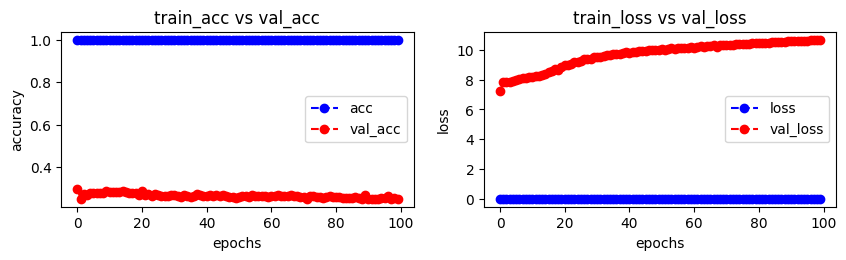

In [17]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

plot_accuracy_loss(history)

In [18]:
predictions = model.predict(X_test)

# Convert the logits to probabilities
probabilities = tf.nn.softmax(predictions)

# Get the class with the highest probability
predicted_classes = np.argmax(probabilities, axis=1)

# Compare the predicted classes with the actual classes
comparison = list(zip(predicted_classes, y_test))

# Display the first 10 predictions and actual values
for i in range(10):
    print(f'Predicted: {predicted_classes[i]}, Actual: {y_test[i]}')

9/9 [==============================] - 0s 21ms/step
Predicted: 10, Actual: 2
Predicted: 3, Actual: 12
Predicted: 3, Actual: 6
Predicted: 5, Actual: 4
Predicted: 11, Actual: 12
Predicted: 10, Actual: 10
Predicted: 0, Actual: 8
Predicted: 3, Actual: 8
Predicted: 5, Actual: 5
Predicted: 3, Actual: 3
